In [47]:
import yelpapi
import json
import requests
from  pprint import  pprint
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns


#reading in county data
counties=pd.read_csv("acs2015_county_data.csv")
counties["county_string"] = counties["County"] + " County, " + counties["State"]
listofcounties = counties["county_string"].tolist()
#reading in zipcodes
zipcodes=pd.read_csv("zip_codes_states.csv")
zipcodes["county_string"] = zipcodes["county"] + " County, " + zipcodes["state"]
listofzipcodes=zipcodes["county_string"].unique().tolist()
counties.to_csv("counties.csv")
zipcodes.to_csv("zcs.csv")
fullcountylist = list(set(listofcounties) & set(listofzipcodes))
counties.head(1)

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,county_string
0,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,...,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6,"Autauga County, Alabama"


In [48]:
#creating regions
WC = ["Washington","Oregon","California","Nevada","Idaho"]
MW = ["Montana","Wyoming","North Dakota","South Dakota","Nebraska","Kansas","Minnesota","Iowa","Missouri",
      "Wisconsin","Illinois","Michigan","Indiana","Ohio","Kentucky"]
SW = ["Arizona","Utah","Colorado","New Mexico","Oklahoma","Texas"]
SE = ["Arkansas","Louisiana","Mississippi","Alabama","Tennessee","Virginia","West Virginia","North Carolina","South Carolina","Georgia","Florida"]
NE = ["District of Columbia","Pennsylvania","Maryland","Delaware","New Jersey","New York","Maine","New Hampshire","Vermont","Massachusetts","Rhode Island","Connecticut"]
counties["Region"]= np.where(counties["State"].isin(WC),'WC',
                    np.where(counties["State"].isin(MW),'MW',
                    np.where(counties["State"].isin(SW),'SW',
                    np.where(counties["State"].isin(SE),'SE',
                    np.where(counties["State"].isin(NE),'NE', 
                             'other')))))

In [49]:
#counties.groupby(["Region"]).sum()["TotalPop"]
cdf = pd.DataFrame(counties,columns=["county_string","Region"])
WClist = (cdf.groupby("Region").get_group("WC")["county_string"]).tolist()
MWlist = (cdf.groupby("Region").get_group("MW")["county_string"]).tolist()
SWlist = (cdf.groupby("Region").get_group("SW")["county_string"]).tolist()
SElist = (cdf.groupby("Region").get_group("SE")["county_string"]).tolist()
NElist = (cdf.groupby("Region").get_group("NE")["county_string"]).tolist()

sample_list = []
sample_list.extend(random.sample(list(set(WClist) & set(fullcountylist)),2))
sample_list.extend(random.sample(list(set(MWlist) & set(fullcountylist)),2))
sample_list.extend(random.sample(list(set(SWlist) & set(fullcountylist)),2))
sample_list.extend(random.sample(list(set(SElist) & set(fullcountylist)),2))
sample_list.extend(random.sample(list(set(NElist) & set(fullcountylist)),2))
sample_list

['San Diego County, California',
 'Nevada County, California',
 'Miami County, Ohio',
 'Lewis County, Missouri',
 'Lea County, New Mexico',
 'Wasatch County, Utah',
 'Cherokee County, South Carolina',
 'Webster County, West Virginia',
 'Lehigh County, Pennsylvania',
 'Putnam County, New York']

In [50]:
res_df = pd.DataFrame(columns=["name","zipcode","county_string","rating","review_count","category","price","region"])
res_df

,name,zipcode,county_string,rating,review_count,category,price,region


In [51]:
r = 0
for c in sample_list:
    county_string = str(c)
    for term in ["Italian","Mexican","Chinese","American","Indian"]:
        #we are allowed 5000 queries per 24 hours. if we run out, we can create another. till then, use this
        yelpkey="IXRN_1GI8f8J9Kj5O5GciqeyFSWR5RMh41_rADGy1KrtQ5ZABGGZEkWwot5mOka0NlzlNxXPmzYXLWk88oOV0N_YxD1MSW4kQRfJnFrwfHLtKrr2HcsjLo6uWBzAWnYx"
        try:
            offset=0
            for loopcount in range(5):
                
                response = requests.get(url="https://api.yelp.com/v3/businesses/search", 
                       params= {"location": county_string,"term": term, "limit":"50", "offset": offset}, 
                       headers={'Authorization': 'bearer %s' % yelpkey})
                responsejson = response.json()
                offset += 50
                try:
                    count=0
            
                    for x in range(0,49):
                        for y in range(0,len(responsejson["businesses"][x]["categories"])):
                            
                            if ((str(responsejson["businesses"][x]["categories"][y]["title"]).startswith(str(term))) and 
                                (responsejson["businesses"][x]["review_count"] > 0)):
                        
                                zc = int(responsejson["businesses"][x]["location"]["zip_code"])
                                if (zipcodes.loc[zipcodes["zip_code"]==zc]["county_string"].tolist()[0]== county_string):
                            
#                                     print("\n",responsejson["businesses"][x]["name"],
#                                           responsejson["businesses"][x]["location"]["zip_code"],
#                                           zipcodes.loc[zipcodes["zip_code"]==zc]["county_string"].tolist()[0],
#                                           responsejson["businesses"][x]["rating"],
#                                           responsejson["businesses"][x]["review_count"],
#                                           responsejson["businesses"][x]["categories"][y]["title"])
                            
                                    res_df.loc[r]=[responsejson["businesses"][x]["name"],
                                          str(zc),
                                          county_string,
                                          responsejson["businesses"][x]["rating"],
                                          responsejson["businesses"][x]["review_count"],
                                          term,
                                          responsejson["businesses"][x]["price"]]
                                    count += 1
                                    r += 1
                except:
                    break
    
                print("End of list. Found", count, term, "restaurants in", county_string)
        except:
            break


In [52]:

res_df.to_csv("output1804042050.csv")
res_df.price.replace(["$","$$","$$$","$$$$"],[1,2,3,4],inplace=True)
res_df

  

,name,zipcode,county_string,rating,review_count,category,price,region


In [53]:
itadf = res_df.groupby(res_df["category"]).get_group("Italian")
mexdf = res_df.groupby(res_df["category"]).get_group("Mexican")
chndf = res_df.groupby(res_df["category"]).get_group("Chinese")
usadf = res_df.groupby(res_df["category"]).get_group("American")
inddf = res_df.groupby(res_df["category"]).get_group("Indian")
res_df
# CHA = res_df.groupby(res_df["county_string"]).get_group("Mecklenburg County, North Carolina")
# CHAbreakdown = pd.DataFrame(CHA["category"].value_counts()).T.reset_index()
# CHAbreakdown["county_string"]="Mecklenburg County, North Carolina"
# CHA_price_avg = CHA.groupby(res_df["price"]).mean()
# CHA_price_count = CHA["price"].value_counts()

# RAL = res_df.groupby(res_df["county_string"]).get_group("Wake County, North Carolina")
# RALbreakdown = pd.DataFrame(RAL["category"].value_counts()).T.reset_index()
# RALbreakdown["county_string"]="Wake County, North Carolina"
# RAL_price_avg = RAL.groupby(res_df["price"]).mean()
# RAL_price_count = RAL["price"].value_counts()

# ATL = res_df.groupby(res_df["county_string"]).get_group("Fulton County, Georgia")
# ATLbreakdown = pd.DataFrame(ATL["category"].value_counts()).T.reset_index()
# ATLbreakdown["county_string"]="Fulton County, Georgia"
# ATL_price_avg = ATL.groupby(res_df["price"]).mean()
# ATL_price_count = ATL["price"].value_counts()

# MEM = res_df.groupby(res_df["county_string"]).get_group("Shelby County, Tennessee")
# MEMbreakdown = pd.DataFrame(MEM["category"].value_counts()).T.reset_index()
# MEMbreakdown["county_string"]="Shelby County, Tennessee"
# MEM_price_avg = MEM.groupby(res_df["price"]).mean()
# MEM_price_count = MEM["price"].value_counts()


# ORL = res_df.groupby(res_df["county_string"]).get_group("Orange County, Florida")
# ORLbreakdown = pd.DataFrame(ORL["category"].value_counts()).T.reset_index()
# ORLbreakdown["county_string"]="Orange County, Florida"
# ORL_price_avg = ORL.groupby(res_df["price"]).mean()
# ORL_price_count = ORL["price"].value_counts()

# MIL = res_df.groupby(res_df["county_string"]).get_group("Milwaukee County, Wisconsin")
# MILbreakdown = pd.DataFrame(MIL["category"].value_counts()).T.reset_index()
# MILbreakdown["county_string"]="Milwaukee County, Wisconsin"
# MIL_price_avg = MIL.groupby(res_df["price"]).mean()
# MIL_price_count = MIL["price"].value_counts()

# SFC = res_df.groupby(res_df["county_string"]).get_group("San Francisco County, California")
# SFCbreakdown = pd.DataFrame(SFC["category"].value_counts()).T.reset_index()
# SFCbreakdown["county_string"]="San Francisco County, California"
# SFC_price_avg = SFC.groupby(res_df["price"]).mean()
# SFC_price_count = SFC["price"].value_counts()

# AUS = res_df.groupby(res_df["county_string"]).get_group("Travis County, Texas")
# AUSbreakdown = pd.DataFrame(AUS["category"].value_counts()).T.reset_index()
# AUSbreakdown["county_string"]="Travis County, Texas"
# AUS_price_avg = AUS.groupby(res_df["price"]).mean()
# AUS_price_count = AUS["price"].value_counts()

# PIT = res_df.groupby(res_df["county_string"]).get_group("Allegheny County, Pennsylvania")
# PITbreakdown = pd.DataFrame(PIT["category"].value_counts()).T.reset_index()
# PITbreakdown["county_string"]="Allegheny County, Pennsylvania"
# PIT_price_avg = PIT.groupby(res_df["price"]).mean()
# PIT_price_count = PIT["price"].value_counts()


KeyError: 'Italian'

In [ ]:
TOTAL_price_avg = res_df.groupby(["price"]).mean()
rescount = res_df.groupby(["county_string"]).count()["name"].reset_index()
rescount.columns=['county_string', 'restaurant_count']
TOTAL_county_reviews = res_df.groupby(["county_string"]).review_count.sum().reset_index()
TOTAL_county_reviews.columns=["county_string","review_count"]
TOTAL_county_avg = res_df.groupby(res_df["county_string"]).mean().reset_index()

county_stats = TOTAL_county_avg.merge(TOTAL_county_reviews, on="county_string")
csdf = county_stats.merge(counties, on="county_string")
c_df = rescount.merge(csdf, on="county_string")
c_df

In [ ]:
current_county="Spotsylvania County, Virginia"
WCO = res_df.groupby(res_df["county_string"]).get_group(current_county)
WCObreakdown = pd.DataFrame(WCO["category"].value_counts()).T.reset_index()
WCOrate = pd.DataFrame(WCO["rating"].value_counts()).T.reset_index()
WCObreakdown["county_string"]=current_county
WCO_price_avg = WCO.groupby(res_df["price"]).mean()
WCO_price_count = WCO["price"].value_counts()
WCOrate


In [ ]:
comp_df = pd.DataFrame(columns=["Italian","Mexican","Chinese","American", "Indian","county_string"])
comp_df = comp_df.append(CHAbreakdown)
comp_df = comp_df.append(RALbreakdown)
comp_df = comp_df.append(ATLbreakdown)
comp_df = comp_df.append(MEMbreakdown)
comp_df = comp_df.append(ORLbreakdown)
comp_df = comp_df.append(MILbreakdown)
comp_df = comp_df.append(SFCbreakdown)
comp_df = comp_df.append(AUSbreakdown)
comp_df = comp_df.append(PITbreakdown)
comp_df = comp_df.reset_index()
del comp_df["index"]
del comp_df["level_0"]
#comp_df["Totals"]=comp_df["Italian"]+comp_df["Mexican"]+comp_df["Chinese"]+comp_df["Indian"]+comp_df["American"]
comp_df

In [ ]:
fig, axes = plt.subplots(3,3,figsize= (16,9))
for i, (idx, row) in enumerate(comp_df.set_index("county_string").iterrows()):
    ax = axes[i // 3, i % 3]
    row = row[row.gt(row.sum()*.01)]
    ax.pie(row, labels=row.index)
    ax.set_title(idx)
fig.subplots_adjust(wspace=1)

In [ ]:
labels = ["Italian","Mexican","Chinese","American", "Indian"]
# Values of each group
bars =[[],[],[],[]]
for label in labels:
    df= res_df.loc[res_df["category"]==label, :]
    counts = df["price"].value_counts()
    for price in range(1,5):
        try:
            bars[price-1].append(counts[price])
        except: 
            bars[price-1].append(0)
print(bars[1])

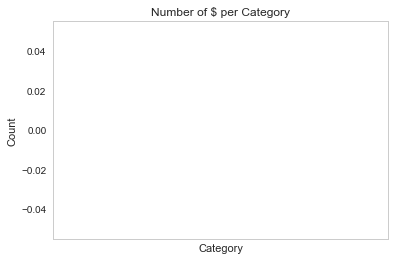

In [42]:
from matplotlib import rc
sns.set()
# orgPalette = sns.color_palette("Set2", len(res_by_price))
# sns.set_palette(orgPalette)
sns.set_style("whitegrid", {'legend.frameon':True})


# y-axis in bold
# rc('font', weight='bold')

figsize= (100, 100, 50)
 
# Values of each group
bars1 = bars[0]
bars2 = bars[1]
bars3 = bars[2]
bars4 = bars[3]
x = np.arange(len(bars1))


plt.bar(x, bars4, color="plum")
plt.bar(x, bars3, color="darkblue", bottom=bars4)
plt.bar(x, bars2, color="turquoise", bottom=list(map(lambda x,y: x+y, bars3,bars4)))
plt.bar(x, bars1, color="darkorange", bottom=list(map(lambda x,y,z: x+y+z, bars3,bars4,bars2)))

plt.xticks(x, ["Italian","Mexican","Chinese","American", "Indian"])

plt.grid(axis='y')
plt.xlabel("Category")
plt.ylabel('Count')
plt.title('Number of $ per Category')

plt.legend()


# Show graphic
plt.show()
plt.savefig("stacked.png")

In [ ]:
c_df["Region"]

In [ ]:
region = ["NE","MW","WC","SW","SE","NE","WC","SE"]
# Values of each group
reg_bars =[[],[],[],[]]
for label in region:
    df1 = c_df.loc[c_df["Region"]==region, :]
    counts = df1["price"].value_counts()
    for price in range(1,5):
        try:
            reg_bars[price-1].append(counts[price])
        except: 
            reg_bars[price-1].append(0)
print(bars[1])

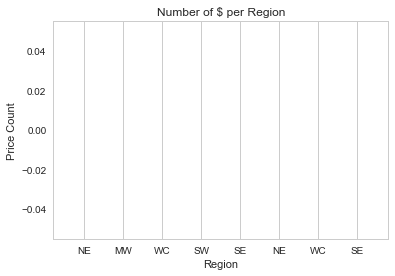

In [39]:
sns.set()
# orgPalette = sns.color_palette("Set2", len(res_by_price))
# sns.set_palette(orgPalette)
sns.set_style("whitegrid", {'legend.frameon':True})

figsize= (100, 100, 50)
 
# Values of each group
bars1 = reg_bars[0]
bars2 = reg_bars[1]
bars3 = reg_bars[2]
bars4 = reg_bars[3]
x = np.arange(len(bars1))


plt.bar(x, bars4, color="plum")
plt.bar(x, bars3, color="darkblue", bottom=bars4)
plt.bar(x, bars2, color="turquoise", bottom=list(map(lambda x,y: x+y, bars3,bars4)))
plt.bar(x, bars1, color="darkorange", bottom=list(map(lambda x,y,z: x+y+z, bars3,bars4,bars2)))

plt.xticks(x, ["NE","MW","WC","SW","SE","NE","WC","SE"])

plt.grid(axis='y')
plt.xlabel("Region")
plt.ylabel('Price Count')
plt.title('Number of $ per Region')

plt.legend()


# Show graphic
plt.show()
plt.savefig("stacked2.png")

In [ ]:
comp = pd.DataFrame(res_df["category"].groupby(res_df["county_string"]).value_counts())
comp
#I HAVE NO IDEA WHAT TO DO WITH THIS

In [ ]:
CHA = CHA["category"].value_counts().reset_index()
CHA["county_string"]="Mecklenburg County, North Carolina"
CHA.columns = ["category","count","county_string"]
CHA